In [63]:
import tensorflow as tf
import zipfile
tfkl = tf.keras.layers
import csv
import numpy as np
import pandas as pd
import os as os
import matplotlib.pyplot as plt
#from keras.layers import Input, Embedding, Flatten, Dense, BatchNormalization, Dropout, concatenate
#from keras.models import Model
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression

# Load in Data

In [64]:
# loading in USMDB data
data = []
ages = []
states = []
genders = []

with open("../data/usmdb/usmdb.csv", "r") as file:
    reader = csv.reader(file,delimiter=',')
    for row_index, row in enumerate(reader):
        if row_index == 0:
            print(row)
        if row_index >= 1:
            state, gender, year, age, rate = row
            year = int(year)
            try:
                age = int(age)
            except:
                age = -1
            if state not in states:
                states.append(state)
            state = states.index(state)
            if gender not in genders:
                genders.append(gender)
            gender = genders.index(gender)
            try:
                rate = float(rate)
            except:
                rate = -1
            if rate > 1:
                rate = 1
            # get rid of years, ages, not in health data and other cleaning
            if age != -1 and rate != -1 and age <= 99 and age >=18 and year >= 1993:
                data.append([state, gender, year, age, rate])

data = np.array(data)

['PopName', 'Sex', 'Year', 'Age', 'mx']


In [9]:
print(data[:,0])
print(data)
print(states)
print(genders)

[ 0.  0.  0. ... 49. 49. 49.]
[[0.0000e+00 0.0000e+00 1.9930e+03 1.8000e+01 2.7000e-04]
 [0.0000e+00 0.0000e+00 1.9930e+03 1.9000e+01 0.0000e+00]
 [0.0000e+00 0.0000e+00 1.9930e+03 2.0000e+01 1.0700e-03]
 ...
 [4.9000e+01 1.0000e+00 2.0200e+03 9.7000e+01 3.8917e-01]
 [4.9000e+01 1.0000e+00 2.0200e+03 9.8000e+01 4.2072e-01]
 [4.9000e+01 1.0000e+00 2.0200e+03 9.9000e+01 4.5292e-01]]
['AK', 'AL', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY']
['f', 'm']


In [65]:
df = pd.read_csv("../data/brfss/brfss_agg.csv", index_col=0)

Last minute cleaning. Will put chunk below into cleaning file soon.

In [66]:
# removing missing - should add this to cleaning dataset in the future
index_missing = df[ (df['sex'] == '7')].index
df.drop(index_missing, inplace=True)

# Mapping from FIPS code to state abbreviation
fips_to_abbreviation = {
    1: 'AL', 2: 'AK', 4: 'AZ', 5: 'AR', 6: 'CA', 8: 'CO', 9: 'CT', 10: 'DE', 12: 'FL',
    13: 'GA', 15: 'HI', 16: 'ID', 17: 'IL', 18: 'IN', 19: 'IA', 20: 'KS', 21: 'KY',
    22: 'LA', 23: 'ME', 24: 'MD', 25: 'MA', 26: 'MI', 27: 'MN', 28: 'MS', 29: 'MO',
    30: 'MT', 31: 'NE', 32: 'NV', 33: 'NH', 34: 'NJ', 35: 'NM', 36: 'NY', 37: 'NC',
    38: 'ND', 39: 'OH', 40: 'OK', 41: 'OR', 42: 'PA', 44: 'RI', 45: 'SC', 46: 'SD',
    47: 'TN', 48: 'TX', 49: 'UT', 50: 'VT', 51: 'VA', 53: 'WA', 54: 'WV', 55: 'WI',
    56: 'WY'
}

# Convert FIPS codes to state abbreviations
df['state'] = df['state'].map(fips_to_abbreviation)

print(df)


      state    age     sex  year        bmi    smokes
0        AL  18-24  female  1993  21.704250  0.183824
1        AL  18-24  female  1994  23.100608  0.256944
2        AL  18-24  female  1995  23.313510  0.258065
3        AL  18-24  female  1996  24.502406  0.286885
4        AL  18-24  female  1997  23.347746  0.196721
...     ...    ...     ...   ...        ...       ...
38849    WY    80+    male  2017  27.069832  0.553846
38850    WY    80+    male  2018  26.646026  0.560000
38851    WY    80+    male  2019  26.365848  0.567839
38852    WY    80+    male  2020  26.726692  0.562189
38853    WY    80+    male  2021  26.220133  0.595855

[37570 rows x 6 columns]


In [67]:
df['year'] = pd.to_numeric(df['year'], errors='coerce')
df['state'] = df['state'].astype('category')
df['state'] = df['state'].apply(lambda x: states.index(x))
df['state'] = df['state'].astype('int64')
df['age'] = df['age'].astype('category')
df['sex'] = df['sex'].map({'female': 0, 'male': 1})
print(df.dtypes)

health_data = df.to_numpy()

state        int64
age       category
sex          int64
year         int64
bmi        float64
smokes     float64
dtype: object


/Users/paigepark/anaconda3/envs/deep/lib/python3.11/site-packages/pandas/core/arrays/categorical.py:528: RuntimeWarning: invalid value encountered in cast
  fill_value = lib.item_from_zerodim(np.array(np.nan).astype(dtype))


# Train no covariate model

In [13]:
# # training and test sets 
# training_index = np.logical_and(data[:, 2] >= 1998, data[:, 2] <= 2010)
# training_data = data[training_index, :]
# print(training_data.shape)

# test_index = np.logical_and(data[:, 2] > 2010, data[:, 2] <= 2015)
# test_data = data[test_index, :]

In [14]:
# training_data = tf.convert_to_tensor(training_data)
# test_data = tf.convert_to_tensor(test_data)
# # cast tensor to type float32
# training_data = tf.cast(training_data, tf.float32)
# test_data = tf.cast(test_data, tf.float32)
# num_train = training_data.shape[0]
# num_test = test_data.shape[0]

In [15]:
# # define function to fetch and process data entries from training or test data 
# def get_data(index, mode):
#     if mode == "train":
#         # randomly selects index from training data between 0 and num_train
#         rand_index = tf.random.uniform([],minval=0, maxval=num_train, dtype=tf.int32) 
#         entry = training_data[rand_index, :]
#     elif mode == "not_random":
#         # selects specified index from test data 
#         entry = test_data[index, :]
#     else: 
#         # for any other value of mode, randomly selects index from test
#         rand_index = tf.random.uniform([],minval=0, maxval=num_test, dtype=tf.int32)
#         entry = test_data[rand_index, :]
#     state, gender, year, age, rate = entry[0], entry[1], entry[2], entry[3], entry[4]
#     year = (year - 1998)/21
#     age = tf.cast(age, tf.int32)
#     state = tf.cast(state, tf.int32)
#     gender = tf.cast(gender, tf.int32)
#     year = tf.reshape(year, [1])
#     age = tf.reshape(age, [1])
#     state = tf.reshape(state, [1])
#     gender = tf.reshape(gender, [1])
#     rate = tf.reshape(rate, [1])
#     return (year, age, state, gender), rate

In [16]:
# use get_data function to set up training and test tensorflow datasets 
# dataset_train = tf.data.Dataset.from_tensor_slices(np.arange(10000))
# dataset_train = dataset_train.repeat()
# dataset_train = dataset_train.map(lambda x: get_data(x, mode="train"), num_parallel_calls=4)
# dataset_train = dataset_train.batch(256)
# dataset_train = dataset_train.prefetch(buffer_size=512)

# dataset_test = tf.data.Dataset.from_tensor_slices(np.arange(10000))
# dataset_test = dataset_test.repeat()
# dataset_test = dataset_test.map(lambda x: get_data(x, mode="test"), num_parallel_calls=4)
# dataset_test = dataset_test.batch(256)
# dataset_test = dataset_test.prefetch(buffer_size=512)

# dataset_test2 = tf.data.Dataset.from_tensor_slices(np.arange(68000))
# dataset_test2 = dataset_test2.map(lambda x: get_data(x, mode="not_random"), num_parallel_calls=4)
# dataset_test2 = dataset_test2.batch(256)
# dataset_test2 = dataset_test2.prefetch(buffer_size=512)

In [17]:
# defining inputs 
# year = tfkl.Input(shape=(1,), dtype='float32', name='Year')
# age =  tfkl.Input(shape=(1,), dtype='int32', name='Age')
# state = tfkl.Input(shape=(1,), dtype='int32', name='State')
# gender = tfkl.Input(shape=(1,), dtype='int32', name='Gender')

# # defining embedding layers 
# age_embed = tfkl.Embedding(input_dim=100, output_dim=5, input_length=1, name='Age_embed')(age)
# age_embed = tfkl.Flatten()(age_embed)

# gender_embed = tfkl.Embedding(input_dim=2, output_dim=5, input_length=1, name='Gender_embed')(gender)
# gender_embed = tfkl.Flatten()(gender_embed)

# state_embed = tfkl.Embedding(input_dim=50, output_dim=5, input_length=1, name='State_embed')(state)
# state_embed = tfkl.Flatten()(state_embed)

# # create feature vector that concatenates all inputs 
# x = tfkl.Concatenate()([year, age_embed, gender_embed, state_embed])
# x1 = x

# # setting up middle layers 
# x = tfkl.Dense(128, activation='tanh')(x)
# x = tfkl.BatchNormalization()(x)
# x = tfkl.Dropout(0.05)(x)

# x = tfkl.Dense(128, activation='tanh')(x)
# x = tfkl.BatchNormalization()(x)
# x = tfkl.Dropout(0.05)(x)

# x = tfkl.Dense(128, activation='tanh')(x)
# x = tfkl.BatchNormalization()(x)
# x = tfkl.Dropout(0.05)(x)

# x = tfkl.Dense(128, activation='tanh')(x)
# x = tfkl.BatchNormalization()(x)
# x = tfkl.Dropout(0.05)(x)

# # setting up output layer 
# x = tfkl.Concatenate()([x1, x])
# x = tfkl.Dense(128, activation='tanh')(x)
# x = tfkl.BatchNormalization()(x)
# x = tfkl.Dropout(0.05)(x)
# x = tfkl.Dense(1, activation='sigmoid', name='final')(x)

# # creating the model 
# model = tf.keras.Model(inputs=[year, age, state, gender], outputs=[x])

In [18]:
# compiling the model
# model.compile(loss='mse', optimizer='adam')

In [19]:
# callbacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.25, patience=3, verbose=0, mode="auto", min_delta=1e-8, cooldown=0, min_lr=0.0)]
# model.fit(dataset_train, steps_per_epoch=1000, validation_data=dataset_test, validation_steps=500, epochs=30, verbose=2, callbacks=callbacks)

# Train covariate model

Merge health and mortality data

In [70]:
# reshape the data to make state, age, gender, and year indexable

age_groups = []
states = []
years = []
# shaped_data = np.empty((50, 13, 2, 29))
shaped_data = np.empty((50, 13, 2, 29, 2))
shaped_data[:] = np.nan

# loop over each row in health_data and extract info about each feature
for row in health_data:
    state = row[0]
    age = row[1]
    gender = row[2]
    year = row[3]
    bmi = row[4]
    smokes = row[5]

    if state not in states:
        states.append(state)
    state = states.index(state)

    if age not in age_groups:
        age_groups.append(age)
    age = age_groups.index(age)

    if year not in years:
        years.append(year)
    year = years.index(year)

    # indices for state, age, gender, year used to determine 
    # location in shaped_data where BMI and smoking should be placed
    shaped_data[state, age, gender, year] = [bmi, smokes]

In [71]:
print(shaped_data)

[[[[[21.7042503   0.18382353]
    [23.10060778  0.25694444]
    [23.31351043  0.25806452]
    ...
    [27.05599481  0.16949153]
    [27.76455802  0.14285714]
    [27.50458595  0.06349206]]

   [[23.81869735  0.25      ]
    [24.42983077  0.37234043]
    [25.37077871  0.33333333]
    ...
    [26.87929958  0.23312883]
    [27.43570636  0.21019108]
    [26.21900881  0.140625  ]]]


  [[[23.55545792  0.19512195]
    [24.02729042  0.296     ]
    [24.30040437  0.26153846]
    ...
    [28.99859367  0.33532934]
    [29.58358227  0.2481203 ]
    [29.94430991  0.24242424]]

   [[26.28092982  0.33766234]
    [26.35717068  0.41891892]
    [25.86120339  0.46666667]
    ...
    [27.84901285  0.41059603]
    [28.16155476  0.40517241]
    [27.86666013  0.37777778]]]


  [[[23.70796832  0.28030303]
    [24.89916168  0.40458015]
    [24.70018053  0.41269841]
    ...
    [29.86051101  0.38647343]
    [30.63685489  0.2712766 ]
    [30.8261217   0.29787234]]

   [[25.60919189  0.37623762]
    [25.75411826

In [72]:
# Impute missing values using the mean of all states

imputed_data = shaped_data.copy()
matching = np.isnan(shaped_data)

# compute mean along state dimension
mean_values = np.nanmean(shaped_data, axis=0)
# mean_values = np.repeat(np.nanmean(shaped_data, axis=0)[np.newaxis, :, :, :], 50, 0)
mean_values_repeated = np.repeat(np.nanmean(shaped_data, axis=0)[np.newaxis, :, :, :, :], 50, axis = 0)

# replace missing values with cooresponding values from mean array 
imputed_data[matching] = mean_values_repeated[matching]

In [74]:
print(imputed_data[0,0,0,0,0])

21.70425030465645


In [75]:
combined_data = []
for i, row in enumerate(data):
    state = row[0]
    gender = row[1]
    year = row[2]
    age = row[3]
    rate = row[4]
    
    age_index = (age - 20) // 5
    if age_index == -1:
        age_index = 0
    if age_index > 12:
        age_index = 12

    state_index = states.index(int(state))

    year_index = years.index(year)

    # creating BMI with 5 year lag - BMI from 5 years prior used to predict mortality
    bmi = imputed_data[state_index, int(age_index), int(gender), year_index - 5, 0]

    # creating smokes with 5 year lag
    smokes = imputed_data[state_index, int(age_index), int(gender), year_index - 5, 1]

    combined_data.append([state, gender, year, age, bmi, smokes, rate])

combined_data = np.array(combined_data)
print(combined_data.shape)
print(combined_data[0,])

(229600, 7)
[0.00000000e+00 0.00000000e+00 1.99300000e+03 1.80000000e+01
 2.73629438e+01 2.34567901e-01 2.70000000e-04]


Train Covariate Model

In [78]:
# Normalize the bmi and smokes variables
for i in range(4, 6):
    combined_data[:, i] = (combined_data[:, i] - np.min(combined_data[:, i])) / (np.max(combined_data[:, i]) - np.min(combined_data[:, i]))


In [79]:
# training and test sets 
training_index = np.logical_and(combined_data[:, 2] >= 1998, combined_data[:, 2] <= 2010)
training_data = combined_data[training_index, :]
print(training_data.shape)

test_index = np.logical_and(combined_data[:, 2] > 2010, combined_data[:, 2] <= 2015)
test_data = combined_data[test_index, :]

(106600, 7)


In [80]:
training_data = tf.convert_to_tensor(training_data)
test_data = tf.convert_to_tensor(test_data)
# cast tensor to type float32
training_data = tf.cast(training_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)
num_train = training_data.shape[0]
num_test = test_data.shape[0]

In [26]:
# # define function to fetch and process data entries from training or test data 
# def get_data(index, mode, include_bmi=True, include_state=True):
#     if mode == "train":
#         # randomly selects index from training data between 0 and num_train
#         rand_index = tf.random.uniform([],minval=0, maxval=num_train, dtype=tf.int32) 
#         entry = training_data[rand_index, :]
#     elif mode == "not_random":
#         # selects specified index from test data 
#         entry = test_data[index, :]
#     else: 
#         # for any other value of mode, randomly selects index from test
#         rand_index = tf.random.uniform([],minval=0, maxval=num_test, dtype=tf.int32)
#         entry = test_data[rand_index, :]
#     state, gender, year, age, bmi, rate = entry[0], entry[1], entry[2], entry[3], entry[4], entry[5]
#     year = (year - 1998)/21
#     age = tf.cast(age, tf.int32)
#     gender = tf.cast(gender, tf.int32)
#     year = tf.reshape(year, [1])
#     age = tf.reshape(age, [1])
#     gender = tf.reshape(gender, [1])
#     rate = tf.reshape(rate, [1])

#      # Conditionally include bmi and state
#     inputs = [year, age, gender]
#     if include_bmi:
#         bmi = tf.reshape(bmi, [1])
#         inputs.append(bmi)
#     if include_state:
#         state = tf.reshape(tf.cast(state, tf.int32), [1])
#         inputs.append(state)

#     return tuple(inputs), rate

In [81]:
# define function to fetch and process data entries from training or test data 
def get_data(index, mode, include_age=True, include_gender=True, include_year=True, include_bmi=True, include_state=True):
    if mode == "train":
        # randomly selects index from training data between 0 and num_train
        rand_index = tf.random.uniform([],minval=0, maxval=num_train, dtype=tf.int32) 
        entry = training_data[rand_index, :]
    elif mode == "not_random":
        # selects specified index from test data 
        entry = test_data[index, :]
    else: 
        # for any other value of mode, randomly selects index from test
        rand_index = tf.random.uniform([],minval=0, maxval=num_test, dtype=tf.int32)
        entry = test_data[rand_index, :]
    state, gender, year, age, bmi, smokes, rate = entry[0], entry[1], entry[2], entry[3], entry[4], entry[5], entry[6]
    gender = tf.cast(gender, tf.int32)
    gender = tf.reshape(gender, [1])
    rate = tf.reshape(rate, [1])

     # Conditionally include bmi and state
    inputs = []
    if include_age:
        age = tf.cast(age, tf.int32)
        age = tf.reshape(age, [1])
        inputs.append(age)
    if include_gender:
        gender = tf.cast(gender, tf.int32)
        gender = tf.reshape(gender, [1])
        inputs.append(gender)
    if include_year:
        year = (year - 1998)/21
        year = tf.reshape(year, [1])
        inputs.append(year)
    if include_bmi:
        bmi = tf.reshape(bmi, [1])
        inputs.append(bmi)
    if include_state:
        state = tf.reshape(tf.cast(state, tf.int32), [1])
        inputs.append(state)

    return tuple(inputs), rate

In [82]:
# use get_data function to set up training and test tensorflow datasets 
def create_dataset(mode, range, include_bmi=True, include_state=True):
    dataset = tf.data.Dataset.from_tensor_slices(np.arange(range))
    dataset = dataset.repeat()
    dataset = dataset.map(lambda x: get_data(x, mode=mode, include_bmi=include_bmi, include_state=include_state), 
                          num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(256)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

dataset_test2 = create_dataset(mode="not_random", range=68000)

# dataset_test = tf.data.Dataset.from_tensor_slices(np.arange(10000))
# dataset_test = dataset_test.repeat()
# dataset_test = dataset_test.map(lambda x: get_data(x, mode="test"), num_parallel_calls=4)
# dataset_test = dataset_test.batch(256)
# dataset_test = dataset_test.prefetch(buffer_size=512)

# dataset_test2 = tf.data.Dataset.from_tensor_slices(np.arange(68000))
# dataset_test2 = dataset_test2.map(lambda x: get_data(x, mode="not_random"), num_parallel_calls=4)
# dataset_test2 = dataset_test2.batch(256)
# dataset_test2 = dataset_test2.prefetch(buffer_size=512)

In [28]:
# def redefine_model(include_bmi=True, include_state=True):
#     # defining inputs 
#     year = tfkl.Input(shape=(1,), dtype='float32', name='Year')
#     age =  tfkl.Input(shape=(1,), dtype='int32', name='Age')
#     gender = tfkl.Input(shape=(1,), dtype='int32', name='Gender')
#     # conditional inputs
#     if include_state:
#         state = tfkl.Input(shape=(1,), dtype='int32', name='State')
#     if include_bmi:
#         bmi = tfkl.Input(shape=(1,), dtype='float32', name='Bmi')

#     # defining embedding layers 
#     age_embed = tfkl.Embedding(input_dim=100, output_dim=5, input_length=1, name='Age_embed')(age)
#     age_embed = tfkl.Flatten()(age_embed)

#     gender_embed = tfkl.Embedding(input_dim=2, output_dim=5, input_length=1, name='Gender_embed')(gender)
#     gender_embed = tfkl.Flatten()(gender_embed)
    
#     if include_state:
#         state_embed = tfkl.Embedding(input_dim=50, output_dim=5, input_length=1, name='State_embed')(state)
#         state_embed = tfkl.Flatten()(state_embed)

#     # create feature vector that concatenates all inputs 
#     # x = tfkl.Concatenate()([year, age_embed, gender_embed, state_embed, bmi])
#     x = tfkl.Concatenate()([year, age_embed, gender_embed] + ([state_embed] if include_state else []) + ([bmi] if include_bmi else []))
#     x1 = x

#     # setting up middle layers 
#     x = tfkl.Dense(128, activation='tanh')(x)
#     x = tfkl.BatchNormalization()(x)
#     x = tfkl.Dropout(0.05)(x)

#     x = tfkl.Dense(128, activation='tanh')(x)
#     x = tfkl.BatchNormalization()(x)
#     x = tfkl.Dropout(0.05)(x)

#     x = tfkl.Dense(128, activation='tanh')(x)
#     x = tfkl.BatchNormalization()(x)
#     x = tfkl.Dropout(0.05)(x)

#     x = tfkl.Dense(128, activation='tanh')(x)
#     x = tfkl.BatchNormalization()(x)
#     x = tfkl.Dropout(0.05)(x)

#     # setting up output layer 
#     x = tfkl.Concatenate()([x1, x])
#     x = tfkl.Dense(128, activation='tanh')(x)
#     x = tfkl.BatchNormalization()(x)
#     x = tfkl.Dropout(0.05)(x)
#     outputs = tfkl.Dense(1, activation='sigmoid', name='final')(x)

#     # creating the model 
#     inputs = [year, age, gender] 
#     if include_state:
#         inputs.append(state)
#     if include_bmi:
#         inputs.append(bmi)
#     # model = tf.keras.Model(inputs=[year, age, state, gender, bmi], outputs=[x])
#     model = tf.keras.Model(inputs=inputs, outputs=outputs)

#     # compiling the model
#     model.compile(loss='mse', optimizer='adam')

#     return model

In [83]:
def redefine_model(include_age=True, include_gender=True, include_year=True, include_bmi=True, include_state=True):
    # conditional inputs
    if include_age:
        age =  tfkl.Input(shape=(1,), dtype='int32', name='Age')
    if include_gender:
        gender = tfkl.Input(shape=(1,), dtype='int32', name='Gender')
    if include_year:
        year = tfkl.Input(shape=(1,), dtype='float32', name='Year')
    if include_state:
        state = tfkl.Input(shape=(1,), dtype='int32', name='State')
    if include_bmi:
        bmi = tfkl.Input(shape=(1,), dtype='float32', name='Bmi')

    # defining embedding layers
    if include_age:
        age_embed = tfkl.Embedding(input_dim=100, output_dim=5, input_length=1, name='Age_embed')(age)
        age_embed = tfkl.Flatten()(age_embed)

    if include_gender:
        gender_embed = tfkl.Embedding(input_dim=2, output_dim=5, input_length=1, name='Gender_embed')(gender)
        gender_embed = tfkl.Flatten()(gender_embed)
    
    if include_state:
        state_embed = tfkl.Embedding(input_dim=50, output_dim=5, input_length=1, name='State_embed')(state)
        state_embed = tfkl.Flatten()(state_embed)

    # create feature vector that concatenates all inputs 
    # x = tfkl.Concatenate()([year, age_embed, gender_embed, state_embed, bmi])
    x = tfkl.Concatenate()(([age_embed] if include_age else []) + ([gender_embed] if include_gender else []) + ([year] if include_year else []) + ([state_embed] if include_state else []) + ([bmi] if include_bmi else []))
    x1 = x

    # setting up middle layers 
    x = tfkl.Dense(128, activation='tanh')(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.Dropout(0.05)(x)

    x = tfkl.Dense(128, activation='tanh')(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.Dropout(0.05)(x)

    x = tfkl.Dense(128, activation='tanh')(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.Dropout(0.05)(x)

    x = tfkl.Dense(128, activation='tanh')(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.Dropout(0.05)(x)

    # setting up output layer 
    x = tfkl.Concatenate()([x1, x])
    x = tfkl.Dense(128, activation='tanh')(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.Dropout(0.05)(x)
    outputs = tfkl.Dense(1, activation='sigmoid', name='final')(x)

    # creating the model 
    inputs = []
    if include_age:
        inputs.append(age)
    if include_gender:
        inputs.append(gender)
    if include_year:
        inputs.append(year)
    if include_state:
        inputs.append(state)
    if include_bmi:
        inputs.append(bmi)
    # model = tf.keras.Model(inputs=[year, age, state, gender, bmi], outputs=[x])
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    # compiling the model
    model.compile(loss='mse', optimizer='adam')

    return model

In [84]:
def get_loss(loss, val_loss):
    loss = np.array(loss)
    val_loss = np.array(val_loss)
    loss = np.mean(loss)
    val_loss = np.mean(val_loss)
    return loss, val_loss

In [31]:
# Specifications
specs = []

In [86]:
print(dataset_train)

<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 1), dtype=tf.int32, name=None), TensorSpec(shape=(None, 1), dtype=tf.int32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.int32, name=None)), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>


In [85]:
# set up data
dataset_train = create_dataset(mode="train", range=10000)
dataset_test = create_dataset(mode="test", range=10000)

loss = []
val_loss = []

# run model once
model = redefine_model()
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.25, patience=3, verbose=0, mode="auto", min_delta=1e-8, cooldown=0, min_lr=0.0)]
history = model.fit(dataset_train, steps_per_epoch=1000, validation_data=dataset_test, validation_steps=500, epochs=30, verbose=2, callbacks=callbacks)
loss.append(history.history['loss'][-1])
val_loss.append(history.history['val_loss'][-1])
avg_loss, avg_val_loss = get_loss(loss, val_loss)

Epoch 1/30
1000/1000 - 8s - loss: 0.0133 - val_loss: 2.6145e-04 - lr: 0.0010 - 8s/epoch - 8ms/step
Epoch 2/30
1000/1000 - 7s - loss: 5.9468e-04 - val_loss: 9.0014e-05 - lr: 0.0010 - 7s/epoch - 7ms/step
Epoch 3/30
1000/1000 - 7s - loss: 3.4145e-04 - val_loss: 2.5722e-04 - lr: 0.0010 - 7s/epoch - 7ms/step
Epoch 4/30
1000/1000 - 7s - loss: 2.4410e-04 - val_loss: 2.7460e-04 - lr: 0.0010 - 7s/epoch - 7ms/step
Epoch 5/30
1000/1000 - 7s - loss: 2.0392e-04 - val_loss: 6.1157e-05 - lr: 0.0010 - 7s/epoch - 7ms/step
Epoch 6/30
1000/1000 - 7s - loss: 1.8072e-04 - val_loss: 8.7654e-05 - lr: 0.0010 - 7s/epoch - 7ms/step
Epoch 7/30
1000/1000 - 7s - loss: 1.5629e-04 - val_loss: 1.0426e-04 - lr: 0.0010 - 7s/epoch - 7ms/step
Epoch 8/30
1000/1000 - 8s - loss: 1.4871e-04 - val_loss: 8.2762e-05 - lr: 0.0010 - 8s/epoch - 8ms/step
Epoch 9/30
1000/1000 - 7s - loss: 1.1276e-04 - val_loss: 5.0237e-05 - lr: 2.5000e-04 - 7s/epoch - 7ms/step
Epoch 10/30
1000/1000 - 8s - loss: 1.0884e-04 - val_loss: 5.0879e-05 - lr

In [56]:
# model loop for different specs
results = []
for spec_name, include_bmi, include_state in specs:
    loss = []
    val_loss = []
    dataset_train = create_dataset(mode="train", range=10000, include_bmi=include_bmi, include_state=include_state)
    dataset_test = create_dataset(mode="test", range=10000, include_bmi=include_bmi, include_state=include_state)
    for i in range(1):
        model = redefine_model(include_bmi=include_bmi, include_state=include_state)
        callbacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.25, patience=3, verbose=0, mode="auto", min_delta=1e-8, cooldown=0, min_lr=0.0)]
        history = model.fit(dataset_train, steps_per_epoch=1000, validation_data=dataset_test, validation_steps=500, epochs=30, verbose=2, callbacks=callbacks)
        loss.append(history.history['loss'][-1])
        val_loss.append(history.history['val_loss'][-1])
    avg_loss, avg_val_loss = get_loss(loss, val_loss)
    # results.append((spec_name, avg_loss, avg_val_loss))

Epoch 1/30
1000/1000 - 8s - loss: 0.0143 - val_loss: 4.0733e-04 - lr: 0.0010 - 8s/epoch - 8ms/step
Epoch 2/30
1000/1000 - 8s - loss: 4.9401e-04 - val_loss: 1.2466e-04 - lr: 0.0010 - 8s/epoch - 8ms/step
Epoch 3/30
1000/1000 - 9s - loss: 3.2493e-04 - val_loss: 2.5226e-04 - lr: 0.0010 - 9s/epoch - 9ms/step
Epoch 4/30
1000/1000 - 8s - loss: 2.4633e-04 - val_loss: 7.4758e-05 - lr: 0.0010 - 8s/epoch - 8ms/step
Epoch 5/30
1000/1000 - 8s - loss: 2.1333e-04 - val_loss: 7.4214e-05 - lr: 0.0010 - 8s/epoch - 8ms/step
Epoch 6/30
1000/1000 - 7s - loss: 1.7493e-04 - val_loss: 7.5511e-05 - lr: 0.0010 - 7s/epoch - 7ms/step
Epoch 7/30
1000/1000 - 8s - loss: 1.6181e-04 - val_loss: 9.1726e-05 - lr: 0.0010 - 8s/epoch - 8ms/step
Epoch 8/30
1000/1000 - 8s - loss: 1.4381e-04 - val_loss: 1.0713e-04 - lr: 0.0010 - 8s/epoch - 8ms/step
Epoch 9/30
1000/1000 - 8s - loss: 1.1321e-04 - val_loss: 4.9055e-05 - lr: 2.5000e-04 - 8s/epoch - 8ms/step
Epoch 10/30
1000/1000 - 9s - loss: 1.0839e-04 - val_loss: 4.6118e-05 - lr

In [189]:
print(results)

[('No BMI', 3.335853252792731e-05, 3.244583567720838e-05), ('With BMI', 6.290314922807738e-05, 4.4982434337725864e-05), ('No State or BMI', 6.513160624308512e-05, 5.488997849170119e-05), ('BMI, no State', 6.112269329605624e-05, 5.2879014401696625e-05)]


In [190]:
# Generate LaTeX table
latex_table = "\\begin{table}[H]\n\\centering\n\\begin{tabular}{lcc}\n\\hline\n"
latex_table += "Model Specification & Average Loss & Average Validation Loss \\\\ \\hline\n"
for spec_name, avg_loss, avg_val_loss in results:
    latex_table += f"{spec_name} & {avg_loss:.6f} & {avg_val_loss:.6f} \\\\\n"
latex_table += "\\hline\n\\end{tabular}\n\\caption{Model Performance}\n\\end{table}"

print(latex_table)

\begin{table}[H]
\centering
\begin{tabular}{lcc}
\hline
Model Specification & Average Loss & Average Validation Loss \\ \hline
No BMI & 0.000033 & 0.000032 \\
With BMI & 0.000063 & 0.000045 \\
No State or BMI & 0.000065 & 0.000055 \\
BMI, no State & 0.000061 & 0.000053 \\
\hline
\end{tabular}
\caption{Model Performance}
\end{table}


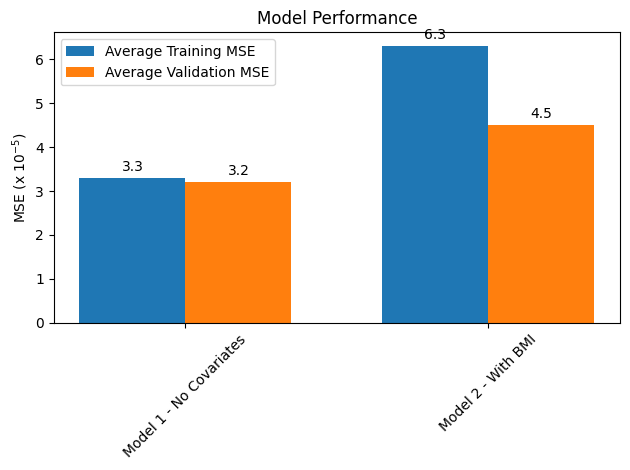

In [6]:
# Data from the table
model_specifications = ['Model 1 - No Covariates', 'Model 2 - With BMI']
average_training_mse = [3.3, 6.3]  # Values multiplied by 10^-5 as per the table caption
average_validation_mse = [3.2, 4.5]  # Values multiplied by 10^-5 as per the table caption

x = np.arange(len(model_specifications))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, average_training_mse, width, label='Average Training MSE')
bars2 = ax.bar(x + width/2, average_validation_mse, width, label='Average Validation MSE')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('MSE (x $10^{-5}$)')
ax.set_title('Model Performance')
ax.set_xticks(x)
ax.set_xticklabels(model_specifications)
ax.legend()

# Function to attach a text label above each bar, displaying its height.
def autolabel(bars):
    """Attach a text label above each bar in *bars*, displaying its height."""
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(bars1)
autolabel(bars2)

plt.xticks(rotation=45)
plt.tight_layout()

# Show plot
plt.show()
fig.savefig('../results/model_performance.pdf')  # Saves the figure with high resolution


In [40]:
!pip install statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 17.0 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.9/233.9 kB 18.5 MB/s eta 0:00:00


In [49]:
# look at linear model results
import statsmodels.api as sm

# Assuming combined_data is your dataset and already defined
X = combined_data[:,0:4]  # Predictor variables
y = combined_data[:,5]    # Response variable

# Adding a constant term for the intercept
X = sm.add_constant(X)

# Fitting the model
lin_model = sm.OLS(y, X).fit()

# Printing the summary to see the p-values among other statistics
print(lin_model.summary())



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.547
Model:                            OLS   Adj. R-squared:                  0.547
Method:                 Least Squares   F-statistic:                 6.920e+04
Date:                Wed, 10 Apr 2024   Prob (F-statistic):               0.00
Time:                        09:48:04   Log-Likelihood:             3.0857e+05
No. Observations:              229600   AIC:                        -6.171e+05
Df Residuals:                  229595   BIC:                        -6.171e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3607      0.033     11.023      0.0

In [53]:
# looking at correlation between age and bmi - are they possibly proxies? 
from scipy.stats import pearsonr, spearmanr

x = data[:, 4]
y = data[:, 3]

# Pearson correlation
pearson_corr, p_value = pearsonr(x, y)
print(f"Pearson Correlation: {pearson_corr}, P-value: {p_value}")

# Spearman correlation
spearman_corr, p_value = spearmanr(x, y)
print(f"Spearman Correlation: {spearman_corr}, P-value: {p_value}")


Pearson Correlation: 0.7348935464418128, P-value: 0.0
Spearman Correlation: 0.9758727688559806, P-value: 0.0


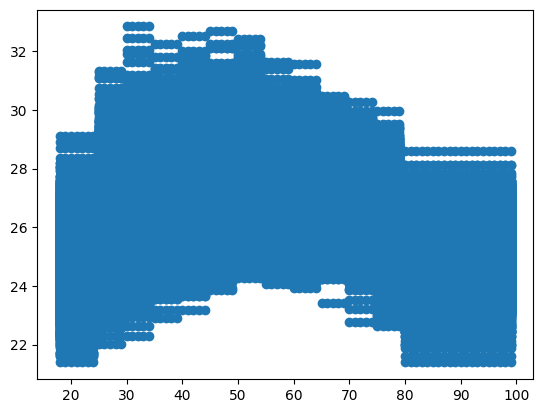

In [50]:
plt.scatter(combined_data[:,3], combined_data[:,4])
plt.show()

In [60]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Age (InputLayer)            [(None, 1)]                  0         []                            
                                                                                                  
 Gender (InputLayer)         [(None, 1)]                  0         []                            
                                                                                                  
 State (InputLayer)          [(None, 1)]                  0         []                            
                                                                                                  
 Age_embed (Embedding)       (None, 1, 5)                 500       ['Age[0][0]']                 
                                                                                            